In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math

from scipy import signal
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run KalmanFilter.ipynb

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 
from IPython.display import clear_output
from tensorflow.python.keras.initializers import RandomUniform

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


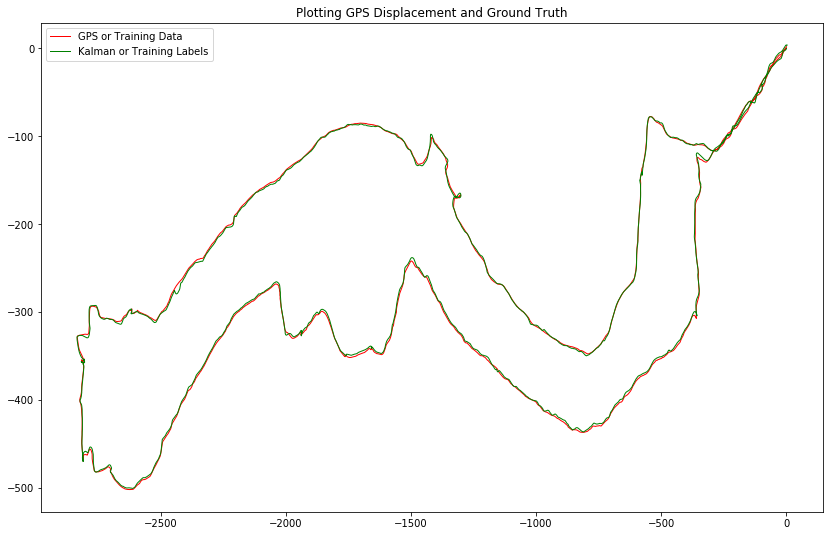

In [3]:
# %load_ext line_profiler
# %lprun -T lprof0 -f Data_Stream.__init__ Data_Stream('uni.csv')
# %cat lprof0

data = Data_Stream('data8.csv')


compute_kalman(data)
plt.figure(figsize=(14, 9))
ax=plt.subplot(111)
plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='GPS or Training Data ') ##
plt.plot(data.kal_dis[:, 1], data.kal_dis[:, 2], 'g-', lw=1, label='Kalman or Training Labels') ##Training Labels
plt.title("Plotting GPS Displacement and Ground Truth") 
ax.legend()

### Get input data and correct labels in the right form

Parameter for choosing whether how much of data stream is training/test data

In [4]:
def create_input_and_output(data, just_acc=False):
    ## Needed Data
    gps = data.gps[:, 1:3]
    acc = data.acc_ERC[:, 1:3]
    vel = data.vel_ERC[:, 1:3]
    mag = data.mag[:, 1:3]
    gyro = data.gyro[:, 1:4]

    time_series = data.acc_ERC[:, 0]
    ground_truth = data.kal_dis[:, 1:3]
    delta_time = np.diff(time_series, axis=0)
    delta_time = np.concatenate(([[0]], delta_time))
    print(delta_time.shape)

    # Choose which data to include in input
    if (just_acc):
        input_data = np.concatenate((gps, acc, delta_time), axis=1)
    else:
        input_data = np.concatenate((gps, acc, delta_time), axis=1)
    return input_data, ground_truth

## Split data for training and testing
input_data, ground_truth = create_input_and_output(data)
x_dim = input_data.shape[1]
y_dim = ground_truth.shape[1]
print("X Dim: ", x_dim)

num_train = int(0.70*input_data.shape[0])
num_test = input_data.shape[0] - num_train

training_data   = input_data[:num_train, :]
training_labels = ground_truth[:num_train, :]

test_data     = input_data[num_train:, :]
test_labels   = ground_truth[num_train:, :]

(163428, 1)
X Dim:  5


### Print Data with Pandas

Training Data


,GPS X,GPS Y,Acc X,Acc Y,Delta Time,Ground Truth X,Ground_Truth Y
114394,-1751.658759,-351.328825,6.114725,-5.230433,0.02018,-1752.973523,-348.425234
114395,-1751.604200,-351.335372,5.945851,-2.724092,0.02017,-1752.913121,-348.431513
114396,-1751.549641,-351.341919,2.591090,3.039162,0.02017,-1752.850277,-348.439574
114397,-1751.495082,-351.348466,-6.576201,10.894456,0.02017,-1752.785727,-348.447736
114398,-1751.440604,-351.355004,0.334576,8.231234,0.02014,-1752.722081,-348.453300


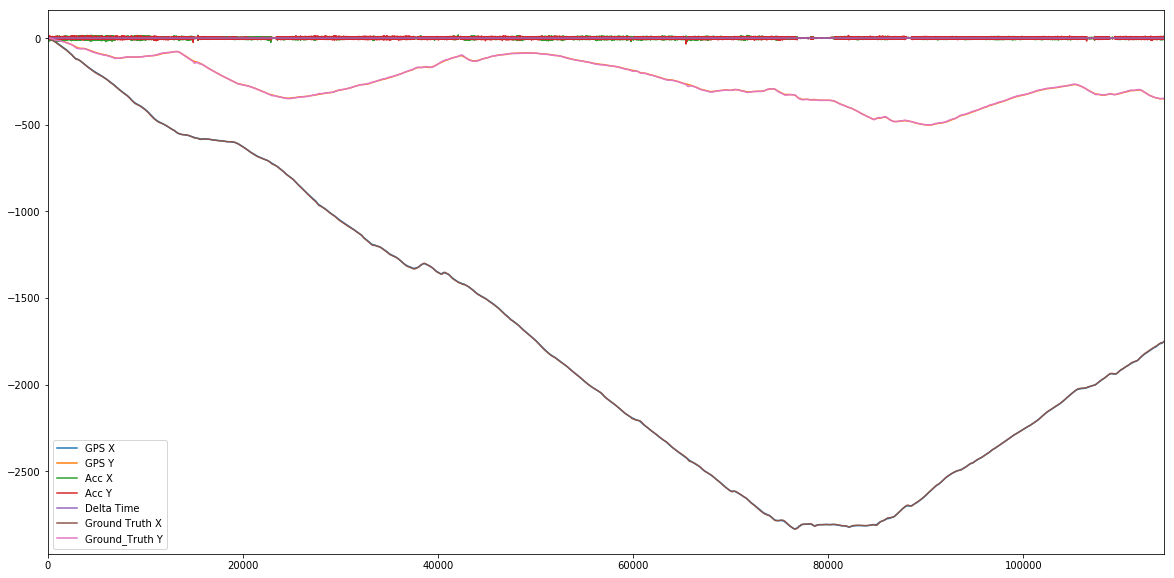

In [5]:
if(False):
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Training Data")
display(training_frame.tail(5))
training_frame.plot(figsize=(20,10))

In [6]:
if(False):
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Testing Data")
display(test_frame.head(5))
# test_frame.plot(figsize=(20,10))


Testing Data


,GPS X,GPS Y,Acc X,Acc Y,Delta Time,Ground Truth X,Ground_Truth Y
0,-1751.386018,-351.361554,0.324140,6.715774,0.02018,-1752.659613,-348.455156
1,-1751.331459,-351.368101,0.362594,5.108257,0.02017,-1752.597046,-348.454252
2,-1751.276900,-351.374648,-3.140174,3.373238,0.02017,-1752.534351,-348.451234
3,-1751.222341,-351.381195,-6.380517,1.566248,0.02017,-1752.472227,-348.446799
4,-1751.167782,-351.387742,-4.983261,-4.731311,0.02017,-1752.412024,-348.441674


### Create Scaling Object to Scale down data to between 0 and 1

In [7]:
x_scaler = MinMaxScaler()
custom_scale_matrix = np.zeros((2, x_dim))
custom_scale_matrix.fill(5000)
custom_scale_matrix[1, :] = -custom_scale_matrix[1 , :]
print(custom_scale_matrix)

x_scaler = x_scaler.fit(custom_scale_matrix)

scaled_training_data = x_scaler.transform(training_data)
scaled_test_data = x_scaler.transform(test_data)

print("Min: ", np.min(training_data[:, 0]), " Max: ", np.max(training_data[:, 0]))
print("Min: ", np.min(scaled_training_data[:, 0]), " Max: ", np.max(scaled_training_data[:, 0]))



[[ 5000.  5000.  5000.  5000.  5000.]
 [-5000. -5000. -5000. -5000. -5000.]]
Min:  -2832.3966927250185  Max:  0.0
Min:  0.21676033072749812  Max:  0.5


Min:  -2833.7539809115074  Max:  0.03379584650008723
Min:  0.21662460190884925  Max:  0.50000337958465


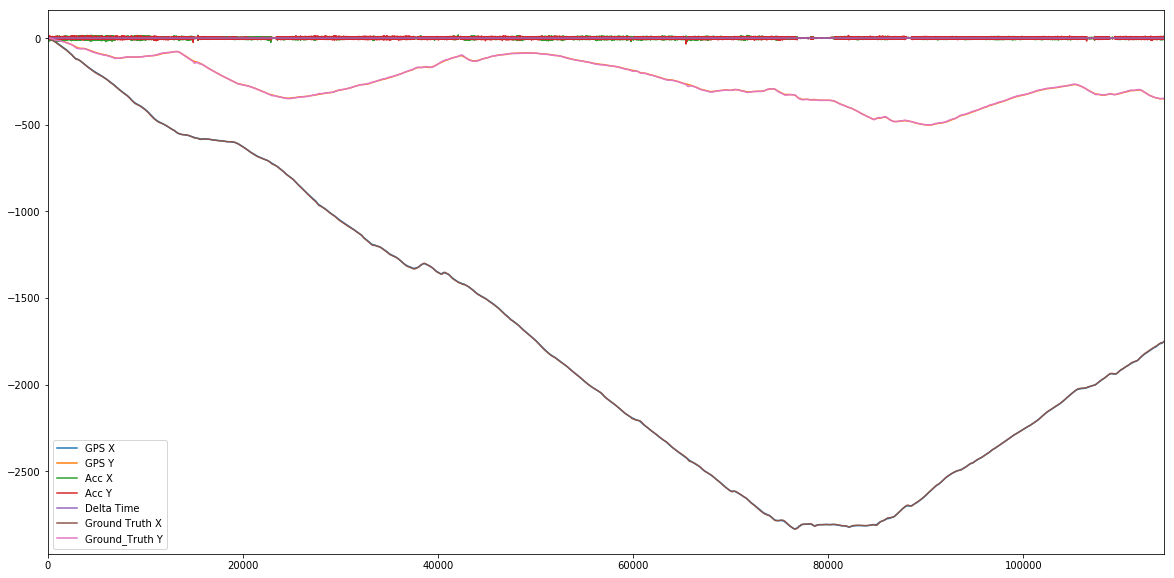

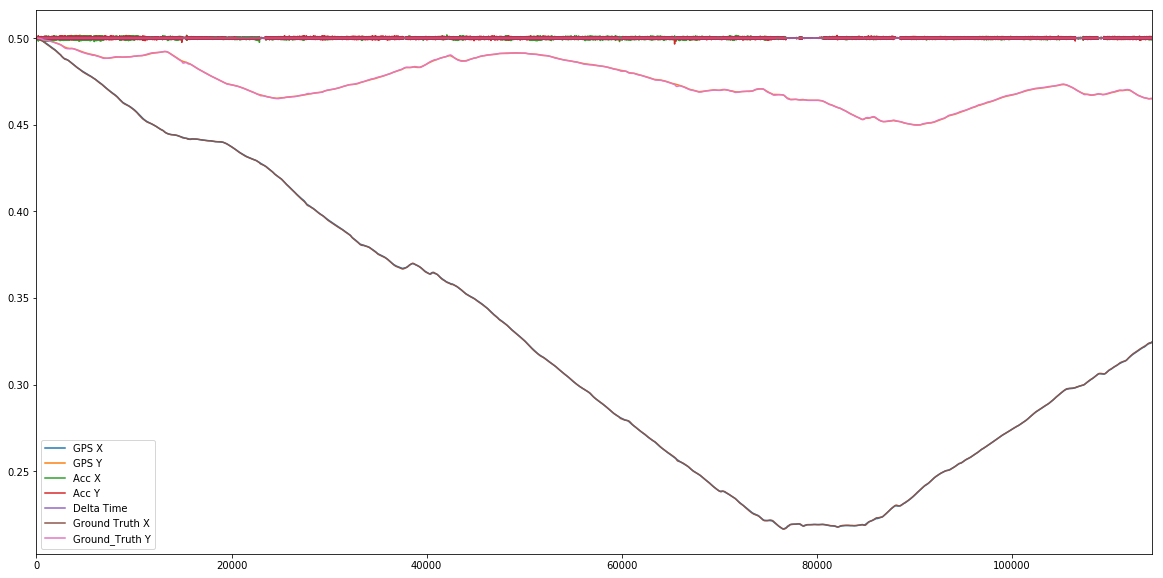

In [8]:
y_scaler = MinMaxScaler()

y_scaler = y_scaler.fit(custom_scale_matrix[:, 0:2])

scaled_training_labels = y_scaler.transform(training_labels)
scaled_test_labels = y_scaler.transform(test_labels)

print("Min: ", np.min(training_labels), " Max: ", np.max(training_labels))
print("Min: ", np.min(scaled_training_labels), " Max: ", np.max(scaled_training_labels))

scaled_training_frame = pd.DataFrame(np.concatenate((scaled_training_data, scaled_training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])

training_frame.plot(figsize=(20,10))
scaled_training_frame.plot(figsize=(20,10))

### Define Batch Generator
Data is currently in a form of N observations, with 5/14 input signals and 2 ouput signals. To be processes by tensorflow 
layers, this is converted to batches of sequences of observations

In [9]:
print(scaled_training_data.shape)
print(scaled_training_labels.shape)

(114399, 5)
(114399, 2)


In [10]:
def batch_generator(batch_size, sequence_length):
    
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, x_dim)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_dim)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
#             rand_start = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
#             x_batch[i] = scaled_training_data[rand_start : rand_start + sequence_length]
#             y_batch[i] = scaled_training_labels[rand_start : rand_start + sequence_length]
            
            x_batch[i] = scaled_training_data[i*sequence_length: i*sequence_length + sequence_length]
            y_batch[i] = scaled_training_labels[i*sequence_length: i*sequence_length + sequence_length]
        
        yield (x_batch, y_batch)

In [11]:
sess = tf.InteractiveSession()

generator = batch_generator(batch_size=math.floor(len(scaled_training_data)/100), sequence_length=100)
x_batch, y_batch = next(generator)
print(x_batch.shape)

(1143, 100, 5)


(1143, 100, 5)
(1143, 100, 2)


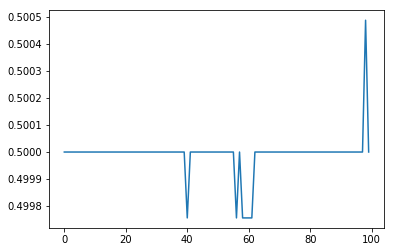

In [12]:
print(x_batch.shape)
print(y_batch.shape) 
batch = 0   # First sequence in the batch.
signal = 2  # Signal, GPS looks like steps as is interpolated at low frequency
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [13]:
validation_data = (np.expand_dims(scaled_test_data, axis=0), np.expand_dims(scaled_test_labels, axis=0))

In [14]:

model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, x_dim,)))#
model.add(Dense(y_dim, activation='linear'))


In [15]:
warmup_steps = 3


In [16]:
def loss_mse_warmup(y_true, y_pred):
    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    
    ts = tf.reshape(y_true_slice,[-1, 2])
    ps = tf.reshape(y_true_slice,[-1, 2])
        
#     ts = tf.Print(ts, [tf.shape(ts)])
        
    def get_min_dist(prev_out, curr_in):
        eu_dists = tf.norm(ts-curr_in, ord='euclidean') 
        return tf.reduce_min(eu_dists)


    min_dists = tf.scan(get_min_dist, ps, initializer=tf.cast(tf.constant(0.), dtype=tf.float32))
    mean_dist = tf.reduce_mean(min_dists)
    

    
    
    loss = tf.losses.absolute_difference(labels=y_true_slice, predictions=y_pred_slice)
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [17]:
optimizer = RMSprop(lr=1e-3)
# model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         795648    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 796,674
Trainable params: 796,674
Non-trainable params: 0
_________________________________________________________________


In [18]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure(figsize=(20, 10))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(20, 10))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             plot_losses,
             callback_reduce_lr]


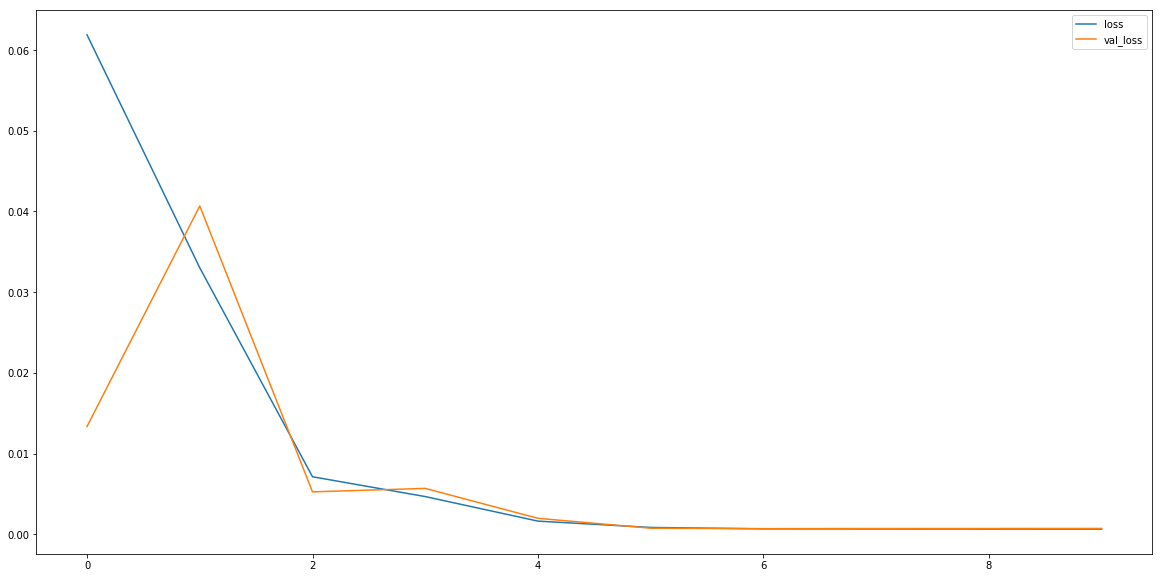

100/100 [==============================] - 30s 303ms/step - loss: 6.3053e-04 - val_loss: 7.1025e-04
Epoch 00010: early stopping
CPU times: user 4min 57s, sys: 38.9 s, total: 5min 36s
Wall time: 5min 6s


In [ ]:
%%time
# model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
#           batch_size=32, validation_data=validation_data, callbacks=callbacks)
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=100, #Number of batches per epoch
                    validation_data=validation_data,
                    callbacks=callbacks)

In [ ]:
result = model.evaluate(x=np.expand_dims(scaled_test_data, axis=0),
                        y=np.expand_dims(scaled_test_labels, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 12s 12s/step
loss (test-set): 0.0007102531963028014


In [ ]:
def plot_comparison(trial_input, ground_truth_output, orig_gps, start_index, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_index: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    trial_input = x_scaler.transform(trial_input)
#     if train:
#         trial_input = scaled_training_data
#         ground_truth_output = training_labels
#     else:
#         trial_input = scaled_test_data
#         ground_truth_output = test_labels
    
    # End-index for the sequences.
    end_index = start_index + length
    
    trial_input = trial_input[start_index : end_index]
    ground_truth_output = ground_truth_output[start_index : end_index]
    
    # Make 3D
    trial_input = np.expand_dims(trial_input, axis=0)
    
    # Predict output
    predicted_output = model.predict(trial_input)
    
    # The output of the model is between 0 and 1. Inverse rescale to get input
    predicted_output = y_scaler.inverse_transform(predicted_output[0])
    
    for signal in range(ground_truth_output.shape[1]):
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the ground truth and Model predicted versions
        plt.plot(ground_truth_output[:, signal], label='true')
        plt.plot(predicted_output[:, signal], label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='red', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("X Displacement" if signal == 0 else "Y Displacement")
        plt.xlabel("Timestep")
        plt.legend()
        plt.show()
        
#     # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(ground_truth_output[:, 0], ground_truth_output[:, 1], label='true', color = 'g')
    plt.plot(predicted_output[:, 0], predicted_output[:, 1], label='predicted', color = 'b')
    plt.plot(orig_gps[start_index:, 1], orig_gps[start_index:, 2], label='original gps', color = 'r')
    plt.legend()
    plt.show()
        

In [ ]:
warmup_steps=20
plot_comparison(input_data, ground_truth, data.gps, start_index=warmup_steps, length=num_train+num_test, train=True)

In [ ]:
plot_comparison(input_data, ground_truth, data.gps, start_index=num_train, length=num_test, train=True)

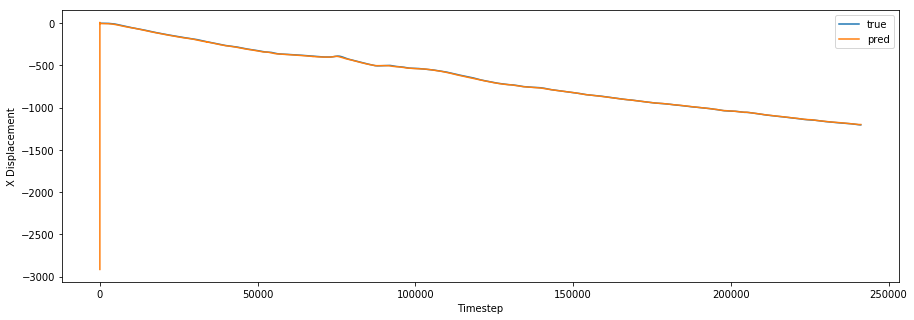

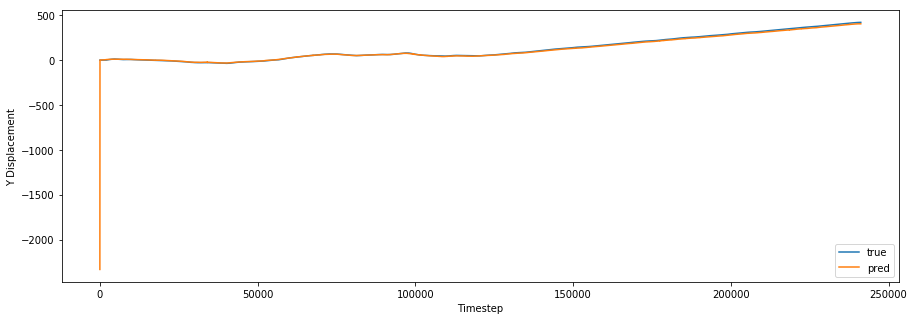

In [ ]:
data2 = Data_Stream('uni.csv')
compute_kalman(data2)

input_data2, ground_truth2 = create_input_and_output(data2)
plot_comparison(input_data2, ground_truth2, data2.gps, start_index=warmup_steps, length=len(input_data2), train=True)

In [ ]:
data2 = Data_Stream('data5.csv')
compute_kalman(data2)

input_data2, ground_truth2 = create_input_and_output(data2)
plot_comparison(input_data2, ground_truth2, data2.gps, start_index=warmup_steps, length=len(input_data2), train=True)

In [ ]:
# tf.reset_default_graph()
# sess.close()